# Lab 5

**Authors**: Emilio Dorigatti, Tobias Weber

Welcome to the fifth lab.

In this lab, we will finally use PyTorch as a deep learning framework.
We will see what are the signs of overfitting, and how to avoid it using regularization.

## Imports

In [ ]:
! pip install torchdata torchtext torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu116

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116


In [ ]:
from collections import Counter
from operator import itemgetter
import random
import string
from typing import Union, List, Tuple, Dict

import torch
from torch import nn, Tensor
from torch.optim import RMSprop, Adam
from torch.utils.data import DataLoader, Dataset
from torchtext.datasets import IMDB
import matplotlib.pyplot as plt
# from matplotlib_inline.backend_inline import set_matplotlib_formats

# set_matplotlib_formats('png', 'pdf')

## Exercise 1

In this exercise, we will learn the basic usage of PyTorch,
a popular deep learning library.
We already utilized PyTorch in the exercises before but only to construct matrices and
perform operations on them.

The networks that we will use are small enough that they can run on your personal
computer, but, if you need a GPU, you can try Jupyter on Google Colab
(click [here](https://colab.research.google.com/notebooks/intro.ipynb)).
At the beginning of your session, get a GPU by clicking on "Runtime", then "Change runtime type",
then choose "GPU" as hardware accelerator.

### Loading and preparing the dataset

The dataset that we will be working with is the IMDB dataset,
which is included in PyTorch (or more precisely in `torchtext`).
It contains 50,000 reviews that are highly polarized,
that is, they are unambiguously either 'positive' or 'negative'.
When the data is loaded, the training and test sets will contain 25,000 reviews each.
In both sets, half of the reviews are positive and half are negative.

In [ ]:
train_iterator, test_iterator = IMDB()

In [ ]:
_iter = iter(train_iterator)

for _ in range(10):
  print(next(_iter))
i = 0
labels = set()
for example in iter(train_iterator):
  i += 1
  labels.add(example[0])
print(i)
print(labels)

(1, 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far between

The `IMDB` object returns two iterators, which allows to iterate over the data.
However, for us it is more convenient to just have everything directly, so we load
the whole dataset into a list.

In [ ]:
train_x: List = []
train_y: List = []
test_x: List = []
test_y: List = []

for label, line in train_iterator:
    train_x.append(line)
    train_y.append(label)

for label, line in test_iterator:
    test_x.append(line)
    test_y.append(label)

Let's check a random review!

In [ ]:
print(train_x[random.randint(0, len(train_x) - 1)])

I am not a big fan of Rajnikant in the first place, but Baba was a huge disappointment. In between an awful storyline, the action and songs were only mediocre. The storyline becomes very preachy. Instead of running for office like NTR or MGR, Rajni almost appeared to be running as Tamil Nadu's next big guru. My wife tells me that since this film came out, Rajni swore off doing any more movies!<br /><br />We were lucky initially to have bought Babu (an oldie by Sivajiganeshan) online by accident when trying to buy this one....that was a great film, which made up for having bought this dud...except it makes Baba look even worse by comparison!<br /><br />Bryan


This looks nice but this is not a good representation for neural network training.
Thus, we apply some preprocessing in the next steps:

1. Tokenization.
2. Count-vectorization.
3. Convert to "bag of words" vectors.
4. Convert string labels to binary.
5. Create a PyTorch dataset.

We start with removing punctuation and isolating single words. This is a very basic
approach for tokenization.

In [ ]:
def tokenize(data_list: List[str]) -> List[List[str]]:
    """
    Tokenize a list of strings.

    :param data_list: A list of strings.
    :return: A list where each entry is a list including the tokenized elements.
    """
    token_list: List[List[str]] = []
    for data_string in data_list:
        # Remove punctuation.
        data_string = data_string.translate(str.maketrans('', '', string.punctuation))
        # Split by space.
        token_list.append(data_string.split())
    return token_list

train_x = tokenize(train_x)
test_x = tokenize(test_x)

print(train_x[0])

['I', 'rented', 'I', 'AM', 'CURIOUSYELLOW', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', 'I', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'US', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'I', 'really', 'had', 'to', 'see', 'this', 'for', 'myselfbr', 'br', 'The', 'plot', 'is', 'centered', 'around', 'a', 'young', 'Swedish', 'drama', 'student', 'named', 'Lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life', 'In', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'Swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'Vietnam', 'War', 'and', 'race', 'issues', 'in', 'the', 'United', 'Sta

Next, we will count all the words and rank them based on their occurrence.
For example, if "film" is the second most word, it will be encoded as `2`.
This process is also called count-vectorization. We also need to save mappings, so that
we can translate between this and the text representation.

In [ ]:
class CountVectorizer:
    def __init__(self):
        self.vec_to_str_map: Dict[int, str] = {}
        self.str_to_vec_map: Dict[str, int] = {}

    def fit(self, token_list: List[str]) -> None:
        # The `Counter` object from the `collections` library gives us efficient counting
        # in large lists out of box.
        cnt = Counter(token_list)
        sorted_cnt = sorted(cnt.items(), key=lambda item: item[1], reverse=True)
        sorted_words = [key for key, val in sorted_cnt]

        # Python does not know a bidirectional mapping by default.
        # We trick a bit by simply creating two dicts, but note that this is inefficient.
        self.str_to_vec_map = {sorted_words[i]: i + 1 for i in range(len(sorted_words))}
        self.vec_to_str_map = {i + 1: sorted_words[i] for i in range(len(sorted_words))}

    def transform_to_vec(self, token_list: List[str]) -> List[int]:
        return [self.str_to_vec_map.get(word) for word in token_list]

    def transform_to_str(self, token_list: List[int]) -> List[str]:
        return [self.vec_to_str_map.get(rank) for rank in token_list]

train_words = [word for word_list in train_x for word in word_list]
test_words = [word for word_list in test_x for word in word_list]

count_vectorizer = CountVectorizer()
counter = count_vectorizer.fit(train_words)

train_x = [count_vectorizer.transform_to_vec(word_list) for word_list in train_x]
test_x = [count_vectorizer.transform_to_vec(word_list) for word_list in test_x]

A sentence is now a list of integers:

In [ ]:
print(train_x[0])

[8, 1595, 8, 13839, 41850, 35, 70, 434, 1191, 80, 4, 32, 1, 7739, 9, 3423, 10, 55, 10, 13, 89, 654, 7, 7978, 8, 91, 559, 9, 30, 89, 10, 13, 22086, 31, 835, 10359, 60, 10, 129, 787, 5, 3578, 11, 783, 2044, 110, 2, 341, 4, 94, 1165, 3150, 8, 59, 61, 5, 66, 11, 17, 14800, 12, 14, 114, 6, 6504, 187, 2, 199, 4239, 500, 1612, 777, 5011, 34, 481, 5, 847, 330, 72, 67, 41, 128, 121, 826, 72, 481, 5, 1139, 39, 13006, 5, 255, 47, 439, 4, 701, 21, 51, 1, 895, 36308, 196, 41, 809, 1008, 1328, 141, 15, 1, 2757, 969, 3, 1672, 1328, 7, 1, 2535, 2532, 121, 194, 2193, 7740, 3, 1999, 20907, 4, 23445, 41, 64, 5012, 21, 2549, 72, 43, 423, 16, 39, 500, 1774, 8513, 3, 1052, 10587, 12, 216, 1116, 71, 41, 8, 13839, 41850, 6, 9, 1831, 154, 614, 11, 13, 1165, 8972, 2069, 1, 423, 3, 1048, 139, 22, 164, 3, 243, 194, 65, 107, 37, 24, 333, 36, 47, 6972, 88, 5058, 441, 70, 26996, 357, 162, 10, 1635, 7, 677, 423, 3, 1048, 22, 2, 723, 10818, 7, 4239, 496, 380, 15931, 5218, 5059, 64, 1564, 5, 48, 175, 522, 305, 2092, 61

We can convert it back using the fitted `CountVectorizer`:

In [ ]:
print(count_vectorizer.transform_to_str(train_x[0]))

['I', 'rented', 'I', 'AM', 'CURIOUSYELLOW', 'from', 'my', 'video', 'store', 'because', 'of', 'all', 'the', 'controversy', 'that', 'surrounded', 'it', 'when', 'it', 'was', 'first', 'released', 'in', '1967', 'I', 'also', 'heard', 'that', 'at', 'first', 'it', 'was', 'seized', 'by', 'US', 'customs', 'if', 'it', 'ever', 'tried', 'to', 'enter', 'this', 'country', 'therefore', 'being', 'a', 'fan', 'of', 'films', 'considered', 'controversial', 'I', 'really', 'had', 'to', 'see', 'this', 'for', 'myselfbr', 'br', 'The', 'plot', 'is', 'centered', 'around', 'a', 'young', 'Swedish', 'drama', 'student', 'named', 'Lena', 'who', 'wants', 'to', 'learn', 'everything', 'she', 'can', 'about', 'life', 'In', 'particular', 'she', 'wants', 'to', 'focus', 'her', 'attentions', 'to', 'making', 'some', 'sort', 'of', 'documentary', 'on', 'what', 'the', 'average', 'Swede', 'thought', 'about', 'certain', 'political', 'issues', 'such', 'as', 'the', 'Vietnam', 'War', 'and', 'race', 'issues', 'in', 'the', 'United', 'Sta

Before we feed the reviews to the network, we need to convert them from sequences of
integers to "bag of words" vectors. For example, turning the sequence (3,5,9)
into a 10 dimensional vector gives us (0,0,1,0,1,0,0,0,1,0),
which has a 1 in the positions 3, 5 and 9 and zeros everywhere else.

We only keep the 10,000 most common words, which will be the size of the input vector.

In [ ]:

def get_index_vector(sequence: List[int], size: int = 10000) -> List[int]:
    output_vec = [0 for _ in range(size)]
    for index in sequence:
        if index is None:
            continue
        elif index <= size - 1:
            output_vec[index] = 1
    return output_vec

train_x = [get_index_vector(count_vector) for count_vector in train_x]
test_x = [get_index_vector(count_vector) for count_vector in test_x]

Lastly we need to convert the labels to a fitting format as well.
As we only have a binary outcome, our label will be 1 for positive and
0 for negative reviews.

In [ ]:
train_y = [1 if label == 2 else 0 for label in train_y]
test_y = [1 if label == 2 else 0 for label in test_y]

We now have everything ready to built a Pytorch `Dataset` object,
which is recommended for the training process.

We also define `device`. This indicates the location where we would like to process data.
By default tensors are on the CPU. If we have a GPU, we could set `device` to `cuda` to
utilize GPU power. If we have set a device, we can then push a tensor to the desired location
by calling `<tensor>.to(device)`. Tensors can also be created directly on the device
by specifying the `device` argument on tensor initialization.
In this setting device is set to `cuda` if a GPU is
available, otherwise we'll just use the cpu.

Pushing the whole dataset to GPU is often not a possibility due to memory constraints,
but in this exercise the small vectorized IMDB data will only consume around 3GB VRAM.
We could also save memory by reducing the size of the input vector or using sparse tensors.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class IMDBDataset(Dataset):
    def __init__(self, data: Union[List, Tuple], labels: List, device: torch.device):
        self.data = torch.tensor(data, dtype=torch.float, device=device)
        self.labels = torch.tensor(labels, dtype=torch.float, device=device)

    # We don't need this method necessarily,
    # but it is usually good to have direct access to the dimensions of the dataset.
    @property
    def shape(self) -> Tuple:
        return self.data.shape

    # The `__len__` method should return the number of samples in the dataset.
    # This will later on be used automatically by the data loader.
    def __len__(self) -> int:
        return len(self.labels)

    # Each Dataset needs to implement the `__get_item__` method.
    # The method gets an index and should return the corresponding items.
    # For example index = 5 should return the 5th review and its matching label.
    def __getitem__(self, idx: int) -> Tuple[Tensor, Tensor]:
        return self.data[idx], self.labels[idx]

In [ ]:
print(device)

cuda


Let’s also create a validation set to monitor the (generalization) performance of the model during training,
by randomly taking the 10,000 samples of the training data and the corresponding labels.
The new training set should contain only the remaining 15,000 samples.

In [ ]:
# Get random indices for training and validation split
shuffled_indices = list(range(len(train_x)))
random.shuffle(shuffled_indices)

train_idxs = shuffled_indices[:15000]
val_idxs = shuffled_indices[15000:]

# Plain python does not know multi index selection
# We can still use `itemgetter` from the `operator` module to achieve what we want.
val_x = itemgetter(*val_idxs)(train_x)
val_y = itemgetter(*val_idxs)(train_y)

train_x = itemgetter(*train_idxs)(train_x)
train_y = itemgetter(*train_idxs)(train_y)

# We can now finally initialize our PyTorch datasets.
train_dataset = IMDBDataset(train_x, train_y, device)
val_dataset = IMDBDataset(val_x, val_y, device)
test_dataset = IMDBDataset(test_x, test_y, device)

print('Training\t Shape: {}'.format(train_dataset.shape))
print('Validation\tShape: {}'.format(val_dataset.shape))
print('Test\t\tShape: {}'.format(test_dataset.shape))

Training	 Shape: torch.Size([15000, 10000])
Validation	Shape: torch.Size([10000, 10000])
Test		Shape: torch.Size([25000, 10000])


Our data is now ready to be fed to a neural network.

Let's remove the preprocessed data lists to free some RAM:

In [ ]:
del train_x
del train_y
del val_x
del val_y
del test_x
del test_y

### Building the network
When deciding on an architecture for a neural network with fully connected layers,
the two key things to consider are:

 - The number of hidden layers in the network
 - The number of neurons in each of the hidden layers

Increasing the depth of the network (that is, adding layers) or increasing the number
of neurons in a given layer will increase the capacity of the network and allow it
to learn more complex non-linear decision boundaries.
However, making the network too large can lead to overfitting.

In practice, deciding on an architecture is an iterative process where
many different networks are trained in order to find a good setting for the
hyperparameters. For this exercise, however, we will use a simple feedforward neural
network with two fully-connected hidden layers consisting of 16 neurons each,
and a single output neuron which outputs the probability of the review being 'positive'.

In PyTorch the `nn` module holds all building blocks that we need.
The `Sequential` module allows us to specify a neural network layer by layer.
A fully connected layer is available as `Linear`.
Simiarly we can import the activation functions as `ReLU` and `Sigmoid`.
We need to push the model to our `device` as well.

In [ ]:
input_size = train_dataset.shape[1]

model = nn.Sequential(
    nn.Linear(in_features=input_size, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=16),
    nn.ReLU(),
    nn.Linear(in_features=16, out_features=1),
    nn.Sigmoid()
).to(device)

In [ ]:
len(train_dataset)
labels = set([train_dataset[i][1].item() for i in range(len(train_dataset))])
print(labels)

{0.0, 1.0}


So, we've built our model. Before we can train the network, however, we must specify:

1. The loss function to use (mean squared error, cross entropy, etc) (Info: [here](https://pytorch.org/docs/stable/nn.html#loss-functions))
2. The optimizer (SGD, Adam, RMSProp, etc.) (Info: [here](https://pytorch.org/docs/stable/optim.html))
3. Any metrics (such as accuracy) used to measure the performance of the model

In [ ]:

loss = (
    nn.BCELoss()
)

optimizer = (
    RMSprop(model.parameters(), lr=1e-3)
)

def get_accuracy(prediction: Tensor, target: Tensor) -> float:
    return float(torch.sum(((prediction > 0.5) == target).float()) / len(prediction))

### Fit
We wish to train the network for 20 epochs with batches of size 512.
In contrast to e.g. Keras, in the basic PyTorch approach we need to implement our
training routine mostly from scratch. Luckily PyTorch provides a `DataLoader` utility,
which allows to easily sample from our `Datasets`.
On the downside we still need to manage metrics on our own.

The `train` function below implements one version of a training loop.
The outer `for` loop is for the number of training epochs. The inner `for` loop
iterates over the whole dataset with the help of the `Dataloader`.
The output of the dataloader is dependend on batch size and the definition of the
provided `Dataset`. In our case we specified in the `__get_item__` function of
`IMDBDataset` that a  tuple with one training sample and label should be returned.
The dataloader does batching and collating automatically. This means in the backend
the loader utilizes our `__get_item__` method but presents us batched results.
In other words, for a batch size of 512 the loader gives us a tuple of a 512 x 10000
sample matrix and a label vector of length 512, which we directly unpack into `x` and `y`.

The actual training logic is straightforward. First, we need to do a forward pass and
compute the loss. The optimization itself follows three steps.

1. Make sure all gradients of the parameter tensors are zeroed or None (`optim.zero_grad()`)
2. Backpropagate the error (`loss.backward()`)
3. Apply the gradients using the optimizer (`optim.step`)

The validation loop follows the exact same principles, but obviously we don't do any
optimization steps. The `torch.no_grad()` context manager implies that no gradients
are calculated and no results are stashed on the computation. This makes a significant
difference in speed in larger models.

You may notice that we have set the model in training (`model.train()`) and evaluation
(`model.eval()`) mode. For our simple model this doesn't make a difference, but for some
layers like `Dropout` or `BatchNormalization` this setting triggers different policies.

In [ ]:

def train(
    model: nn.Module,
    loss: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_dataset: Dataset,
    val_dataset: Dataset,
    batch_size: int,
    epochs: int
) -> Dict:

    # Define a dict with room for metrics that will be populated during training.
    metrics: Dict = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    # The loader allows to shuffle the training data on the fly.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for ep in range(1, epochs + 1):

        print(f"Epoch: {ep}")

        batch_losses = []
        predictions = []
        targets = []

        for batch_idx, (x, y) in enumerate(train_loader):

            ############################################
            # TRAINING LOGIC
            ############################################
            # Set the model to training mode
            model.train()

            # Forward pass through the model
            y_hat = model(x).squeeze()
            # Obtain the loss
            batch_loss = loss(y_hat, y)

            # Set all parameter gradients to zero
            optimizer.zero_grad()
            # Backpropagate the error
            batch_loss.backward()
            # Apply gradients
            optimizer.step()

            ############################################

            batch_losses.append(batch_loss)
            predictions.append(y_hat.detach())
            targets.append(y)


        ep_train_loss = float(torch.mean(torch.stack(batch_losses)))
        ep_train_acc = get_accuracy(torch.cat(predictions), torch.cat(targets))

        batch_losses.clear()
        predictions.clear()
        targets.clear()

        for batch_idx, (x, y) in enumerate(val_loader):

            ############################################
            # VALIDATION LOGIC
            ############################################
            # Set the model to evaluation mode
            model.eval()

            with torch.no_grad():

                # Forward pass through the model
                y_hat = model(x).squeeze()
                # Obtain the loss
                batch_loss = loss(y_hat, y)
            ############################################

            batch_losses.append(batch_loss)
            predictions.append(y_hat.detach())
            targets.append(y)

        ep_val_loss = float(torch.mean(torch.stack(batch_losses)))
        ep_val_acc = get_accuracy(torch.cat(predictions), torch.cat(targets))

        metrics['train_loss'].append(ep_train_loss)
        metrics['train_acc'].append(ep_train_acc)
        metrics['val_loss'].append(ep_val_loss)
        metrics['val_acc'].append(ep_val_acc)

        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tTRAIN ACCURACY:\t{:.2f}'
              '\tVAL LOSS:\t {:.5f}\tVAL ACCURACY:\t {:.2f}'
              .format(ep, ep_train_loss, ep_train_acc, ep_val_loss, ep_val_acc), end='\r')

    return metrics

metrics = train(
    model=model,
    loss=loss,
    optimizer=optimizer,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=20,
    batch_size=512
)

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20


Let's visualize the training progress.
We can utilize the `metrics` that are returned from our `train` method.

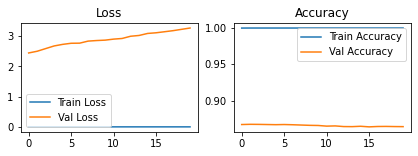

In [ ]:

def get_training_progress_plot(
        train_losses: List[float],
        train_accs: List[float],
        val_losses: List[float],
        val_accs: List[float],
) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 2))

    ax1.set_title('Loss')
    ax1.plot(train_losses, label='Train Loss')
    ax1.plot(val_losses, label='Val Loss')
    ax1.legend()

    ax2.set_title('Accuracy')
    ax2.plot(train_accs, label='Train Accuracy')
    ax2.plot(val_accs, label='Val Accuracy')
    ax2.legend()

get_training_progress_plot(
    metrics['train_loss'],
    metrics['train_acc'],
    metrics['val_loss'],
    metrics['val_acc'],
)

As expected, the training loss decreases with each epoch (and training accuracy increases).
However, the validation loss decreases initially and then begins to increase after
the first few epochs epochs. Therefore, the network has overfit.

### Evaluate
Let's evaluate the performance of the model on the test set:

In [ ]:

def evaluate(model: nn.Module, test_dataset: Dataset, batch_size: int = 512) -> Dict:
    batch_losses: List = []
    predictions: List = []
    targets: List = []

    for x, y in DataLoader(test_dataset, batch_size):
        model.eval()
        with torch.no_grad():
            y_hat = model(x).squeeze()
            batch_loss = loss(y_hat, y)

        ############################################

        batch_losses.append(batch_loss)
        predictions.append(y_hat.detach())
        targets.append(y)

    eval_loss = float(torch.mean(torch.stack(batch_losses)))
    eval_acc = get_accuracy(torch.cat(predictions), torch.cat(targets))

    return {'test_loss': eval_loss, 'test_acc': eval_acc}

eval_metrics = evaluate(model, test_dataset)
print(eval_metrics)

{'test_loss': 3.281343460083008, 'test_acc': 0.8525599837303162}


Our simple model does reasonably well. It achieves an accuracy of around 85-88%.

### Predict
Finally, to generate the likelihood of the reviews being positive, we only need to
forward data through our fitted model:

In [ ]:
test_x = test_dataset.data[:10]
test_y = test_dataset.labels[:10]
predictions = model(test_x)

for i in range(len(test_x)):
    print('{} | TRUE: {} | PRED {:.2e}'.format(i, int(test_y[i]), float(predictions[i])))

0 | TRUE: 0 | PRED 9.82e-24
1 | TRUE: 0 | PRED 9.88e-17
2 | TRUE: 0 | PRED 3.36e-04
3 | TRUE: 0 | PRED 3.42e-30
4 | TRUE: 0 | PRED 1.00e+00
5 | TRUE: 0 | PRED 1.20e-11
6 | TRUE: 0 | PRED 6.86e-11
7 | TRUE: 0 | PRED 2.51e-20
8 | TRUE: 0 | PRED 4.84e-15
9 | TRUE: 0 | PRED 2.63e-23


Now play around with the code by adding and deleting layers, changing the hidden activation, optimizer, learning rate, batch-size, etc.

### Conclusion
Here's what you should take away from this example:

 - You usually need to do quite a bit of preprocessing on your raw data in order to be
able to feed it -- as tensors -- into a neural network.
 - Stacks of dense layers with `ReLU` activations can solve a wide range of problems
(including sentiment classification), and you'll likely use them frequently.
 - As they get better on their training data, neural networks eventually start
_overfitting_ and end up obtaining increasingly worse results on data they have never
seen before. Be sure to always monitor performance on data that is outside of the training set.


## Exercise 2
In this exercise, we will look at a couple of different methods to regularize a neural
network in order to prevent overfitting.

Plotting the validation loss is a simple way to determine whether the network has
overfit. During the first few epochs of training, both the training loss and the
validation loss tend to decrease in tandem but after a certain point, the validation
loss starts to increase while the training loss continues to decrease.
It is at this point that the network begins to overfit.

### Training multiple networks

In order to get a feel for the overfitting behaviour of neural networks,
we will train 3 different architectures and observe the training and validation losses.

Create the first model with two hidden layers, each with 16 units and ReLU activation.

In [ ]:
input_size = train_dataset.shape[1]

original_model = (
        nn.Sequential(
        nn.Linear(in_features=input_size, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=1),
        nn.Sigmoid()
    ).to(device)
)

Our second model will be similar to the first but it will be much smaller.
Reduce the number of neurons in the hidden layers from 16 to 4, and keep everything
else unchanged.

In [ ]:

smaller_model = (
        nn.Sequential(
        nn.Linear(in_features=input_size, out_features=4),
        nn.ReLU(),
        nn.Linear(in_features=4, out_features=4),
        nn.ReLU(),
        nn.Linear(in_features=4, out_features=1),
        nn.Sigmoid()
    ).to(device)
)

We now train both networks network using our `train` function for 20 epochs using a
batch size of 512. Remember to use a separate validation dataset.
We also need to initialize a new optimizer for the model.

In [ ]:
print('Training original model...')
original_model_metrics = train(
    model=original_model,
    loss=nn.BCELoss(),
    optimizer=RMSprop(original_model.parameters()),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=20,
    batch_size=512
)

print('Training smaller model...')
smaller_model_metrics = train(
    model=smaller_model,
    loss=nn.BCELoss(),
    optimizer=RMSprop(smaller_model.parameters()),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=20,
    batch_size=512
)

Training original model...
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20
Training smaller model...
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20


### Plotting the losses

Let's compare the losses over the course of training.

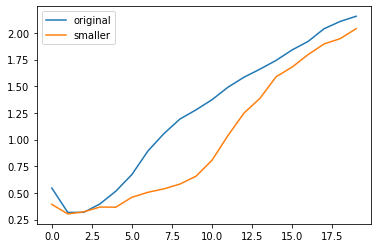

In [ ]:

def compare_losses_plot(
        first_losses: List[float],
        second_losses: List[float],
        first_loss_label: str,
        second_loss_label: str
) -> None:
    plt.plot(first_losses, label=first_loss_label)
    plt.plot(second_losses, label=second_loss_label)
    plt.legend()
    plt.show()

compare_losses_plot(
    original_model_metrics['val_loss'],
    smaller_model_metrics['val_loss'],
    'original',
    'smaller'
)

As you can see, the smaller network starts overfitting later than the original one and
its performance degrades much more slowly once it starts overfitting.

### Third model
Now we build a third neural network that is even bigger than the original network.
If the previous plot is any indication, this new network should overfit even worse
than the original model.

In [ ]:

bigger_model = (
        nn.Sequential(
        nn.Linear(in_features=input_size, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=512),
        nn.ReLU(),
        nn.Linear(in_features=512, out_features=1),
        nn.Sigmoid()
    ).to(device)
)

Let's train this network:

In [ ]:
print('Training bigger model...')
bigger_model_metrics = train(
    model=bigger_model,
    loss=nn.BCELoss(),
    optimizer=Adam(bigger_model.parameters()),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=20,
    batch_size=512
)

Training bigger model...
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20


Here's how the bigger network fares compared to the reference one:

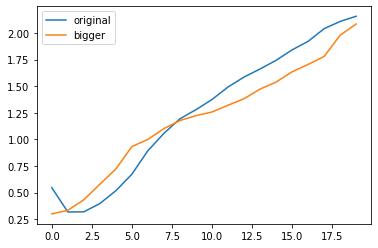

In [ ]:
compare_losses_plot(
    original_model_metrics['val_loss'],
    bigger_model_metrics['val_loss'],
    'original',
    'bigger'
)

The bigger network starts overfitting almost right away, after just one epoch
and overfits much more severely. Its validation loss is also more noisy.

Let's plot the training losses:

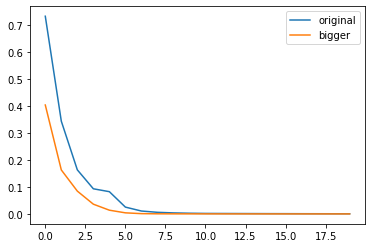

In [ ]:
compare_losses_plot(
    original_model_metrics['train_loss'],
    bigger_model_metrics['train_loss'],
    'original',
    'bigger'
)

As you can see, the bigger network gets its training loss near zero very quickly.
The more capacity the network has, the quicker it will be able to model the training
data (resulting in a low training loss), but the more susceptible it is to overfitting
(resulting in a large difference between the training and validation loss).

### Adding weight regularization

Regularizing a model in PyTorch can be done over the additional `weight_decay`
argument in the optimizer function. By setting a coefficient there, the linked
parameters will have a L2 penalty.

In the following we redeclare the original model, set an optimizer with
`weight_decay` coefficient of 0.001 and fit it.

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20


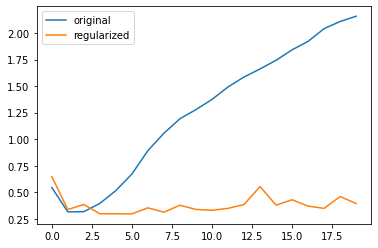

In [ ]:
regularized_model = nn.Sequential(
        nn.Linear(in_features=input_size, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=16),
        nn.ReLU(),
        nn.Linear(in_features=16, out_features=1),
        nn.Sigmoid()
).to(device)

regularized_model_metrics = train(
    model=regularized_model,
    loss=nn.BCELoss(),
    optimizer=RMSprop(regularized_model.parameters(), weight_decay=0.001),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=20,
    batch_size=512
)

compare_losses_plot(
    original_model_metrics['val_loss'],
    regularized_model_metrics['val_loss'],
    'original',
    'regularized'
)

As you can see, the regularized model does not overfit as much,
even though both models have the same number of parameters.
Feel free to play with the regularization strength to get a feel on how different
settings affect learning. When is regularization preventing the network from
learning anything at all? When is regularization so weak it does not make a difference?

### Dropout regularization
Dropout is a very popular technique to regularize neural nets.
It works by randomly turning off (or "dropping out")  the input/hidden neurons in a
network. This means that every neuron is trained on a different set of examples.
Note that dropout is, in most cases, only used during training time.
At test time, all units are used with their activations scaled down by the dropout rate
to account for the fact that all neurons were used for the prediction.
Normally, dropout is not applied to the inputs.

In Keras, dropout is implemented as its own separate layer (`Dropout`) that takes as
input the probability to _drop_ units. To apply dropout to a layer, place a `Dropout` after
it while stacking layers. The dropout will be ignored if the model is in `eval` mode.
Luckily, we already set the correct modes for training and evaluation in our `train`
function.

Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4
Epoch: 5
Epoch: 6
Epoch: 7
Epoch: 8
Epoch: 9
Epoch: 10
Epoch: 11
Epoch: 12
Epoch: 13
Epoch: 14
Epoch: 15
Epoch: 16
Epoch: 17
Epoch: 18
Epoch: 19
Epoch: 20


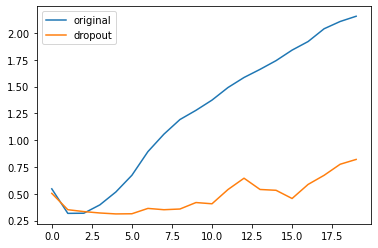

In [ ]:
dropout_model = nn.Sequential(
        nn.Linear(in_features=input_size, out_features=16),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=16, out_features=16),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=16, out_features=1),
        nn.Sigmoid()
).to(device)

dropout_model_metrics = train(
    model=dropout_model,
    loss=nn.BCELoss(),
    optimizer=RMSprop(dropout_model.parameters()),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=20,
    batch_size=512
)

compare_losses_plot(
    original_model_metrics['val_loss'],
    dropout_model_metrics['val_loss'],
    'original',
    'dropout'
)

Once again, we see a marked improvement in the new model.

### Early Stopping

Previously, we were training the network and checking _after training_ when it started
to overfit. But another very popular method to regularize a network is to stop
training earlier than the specified number of epochs, by checking when the validation
loss starts to increase.

There are no out of box utilities to achieve this kind of behavior, so we will adjust
the training loop accordingly.
We also add the `patience` argument to the function.
`patience` indicates how many epochs to wait for an improvement of the validation loss.
If there is no improvement for more than `patience` epochs, training is interrupted.

NOTE: We only implement a very naive method of early stopping. Usually you would
need to roll back the weights to the epoch, which had the last improvement (early
stopping epoch minus patience). However, checkpointing and caching weights is out
of scope of this exercise.

In [ ]:

def train(
    model: nn.Module,
    loss: nn.Module,
    optimizer: torch.optim.Optimizer,
    train_dataset: Dataset,
    val_dataset: Dataset,
    batch_size: int,
    epochs: int,
    early_stopping: bool = False,
    patience: int = 2,
) -> Dict:

    # Define a dict with room for metrics that will be populated during training.
    metrics: Dict = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
    }

    # Track how often in a row no improvements happen
    early_stopping_strikes = 0

    # The loader allows to shuffle the training data on the fly.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for ep in range(1, epochs + 1):

        batch_losses = []
        predictions = []
        targets = []

        for batch_idx, (x, y) in enumerate(train_loader):
            model.train()

            y_hat = model(x).squeeze()
            batch_loss = loss(y_hat, y)

            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            batch_losses.append(batch_loss)
            predictions.append(y_hat.detach())
            targets.append(y)


        ep_train_loss = float(torch.mean(torch.stack(batch_losses)))
        ep_train_acc = get_accuracy(torch.cat(predictions), torch.cat(targets))

        batch_losses.clear()
        predictions.clear()
        targets.clear()

        for batch_idx, (x, y) in enumerate(val_loader):
            model.eval()

            with torch.no_grad():
                y_hat = model(x).squeeze()
                batch_loss = loss(y_hat, y)

            batch_losses.append(batch_loss)
            predictions.append(y_hat.detach())
            targets.append(y)

        ep_val_loss = float(torch.mean(torch.stack(batch_losses)))
        ep_val_acc = get_accuracy(torch.cat(predictions), torch.cat(targets))

        metrics['train_loss'].append(ep_train_loss)
        metrics['train_acc'].append(ep_train_acc)
        metrics['val_loss'].append(ep_val_loss)
        metrics['val_acc'].append(ep_val_acc)

        print('EPOCH:\t{:5}\tTRAIN LOSS:\t{:.3f}\tTRAIN ACCURACY:\t{:.2f}'
              '\tVAL LOSS:\t {:.5f}\tVAL ACCURACY:\t {:.2f}'
              .format(ep, ep_train_loss, ep_train_acc, ep_val_loss, ep_val_acc), end='\r')

        ###############################################################
        # EARLY STOPPING
        ###############################################################
        if early_stopping and ep > 1:
            if metrics['val_loss'][-2] <= metrics['val_loss'][-1]:
                early_stopping_strikes += 1
            else:
                early_stopping_strikes = 0

            if early_stopping_strikes >= patience:
                break

    return metrics

Let's train the dropout model with early stopping and patience of 2.:

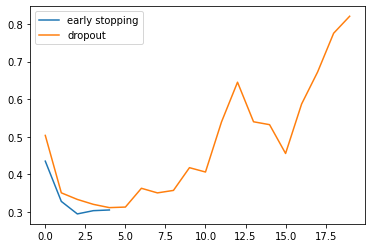

In [ ]:
early_dropout_model = nn.Sequential(
        nn.Linear(in_features=input_size, out_features=16),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=16, out_features=16),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(in_features=16, out_features=1),
        nn.Sigmoid()
).to(device)

early_dropout_model_metrics = train(
    model=early_dropout_model,
    loss=nn.BCELoss(),
    optimizer=RMSprop(early_dropout_model.parameters()),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    epochs=20,
    batch_size=512,
    early_stopping=True,
    patience=2
)

compare_losses_plot(
    early_dropout_model_metrics['val_loss'],
    dropout_model_metrics['val_loss'],
    'early stopping',
    'dropout'
)

As you can see, the early stopping callback worked
and the model was trained for only a few epochs.
Now, evaluate this model on the test data:

In [ ]:

eval_metrics = evaluate(early_dropout_model, test_dataset)
print(eval_metrics)

{'test_loss': 0.31598371267318726, 'test_acc': 0.8766799569129944}


As you can see, the loss is close to the lowest loss in the graph.

The take-home message for this exercise is: large neural networks can easily overfit,
especially with small training sets. This means that the network learns spurious patterns
 that are present in the training data and, therefore, fails to generalize to unseen examples.
 In such a scenario, your options are:

 1. Get more training data
 2. Reduce the size of the network
 3. Regularize the network
